Исчерпывающую информацию с теорией, кодом и примерами можно найти в [статье](https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/)

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight # взвешивание

# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from metrics import precision_at_k, recall_at_k
import itertools
import copy

In [80]:
data = pd.read_csv('../webinar_2/webinar_2/data/transaction_data.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(10)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0
5,2375,26984851516,1,826249,2,1.98,364,-0.60,1642,1,0.0,0.0
6,2375,26984851516,1,1043142,1,1.57,364,-0.68,1642,1,0.0,0.0
7,2375,26984851516,1,1085983,1,2.99,364,-0.40,1642,1,0.0,0.0
8,2375,26984851516,1,1102651,1,1.89,364,0.00,1642,1,0.0,0.0
9,2375,26984851516,1,6423775,1,2.00,364,-0.79,1642,1,0.0,0.0


In [81]:
#train
result_train = data_train.groupby('user_id')['item_id'].unique().reset_index()
result_train.columns=['user_id', 'actual']
result_train.head(2)

,user_id,actual
0,1,"[825123, 831447, 840361, 845307, 852014, 85498..."
1,2,"[854852, 930118, 1077555, 1098066, 5567388, 55..."


In [82]:
#test
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[879517, 934369, 1115576, 1124029, 5572301, 65..."
1,3,"[823704, 834117, 840244, 913785, 917816, 93870..."


In [83]:
#train
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [84]:
#train
# Заведем фиктивный item_id

data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат sparse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15926885,15926886,15926887,15926927,15927033,15927403,15927661,15927850,16809471,17105257
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
#train
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [86]:
%%time
#train
model = AlternatingLeastSquares(factors=100, #количество k или размерность который мы подбираем для матриц при разложении , 
                                # лучший параметр при разложении по версии статьи из вебинара 300-400
                                regularization=0.001,# можно подобрать лучший
                                iterations=15, # можно подобрать лучший
                                calculate_training_loss=True, 
                                num_threads=1) # 4 потока

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=False)

recs = model.recommend(userid=userid_to_id[6],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)

CPU times: user 16.1 s, sys: 1.96 s, total: 18.1 s
Wall time: 7.49 s


In [87]:
[id_to_itemid[rec[0]] for rec in recs]

[923746, 1023720, 1051516, 1007195, 866211]

In [88]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    return res

In [89]:
%%time
#test    
result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

CPU times: user 43 s, sys: 3.95 s, total: 46.9 s
Wall time: 23.6 s


0.14876946258161727

In [90]:
result.head(2)

,user_id,actual,als
0,1,"[879517, 934369, 1115576, 1124029, 5572301, 65...","[1029743, 979707, 995242, 962568, 5569374]"
1,3,"[823704, 834117, 840244, 913785, 917816, 93870...","[1133018, 1106523, 5568378, 5569327, 938700]"


In [91]:
%%time
#train   
result_train['als'] = result_train['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result_train.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

CPU times: user 47.7 s, sys: 4.38 s, total: 52.1 s
Wall time: 26.6 s


0.73664

In [92]:
result_train.head(2)

,user_id,actual,als
0,1,"[825123, 831447, 840361, 845307, 852014, 85498...","[1029743, 979707, 995242, 962568, 5569374]"
1,2,"[854852, 930118, 1077555, 1098066, 5567388, 55...","[1133018, 1106523, 999999, 5569230, 1082185]"


In [93]:
def print_log(row, header=False, spacing=12):
    top = ''
    middle = ''
    bottom = ''
    for r in row:
        top += '+{}'.format('-'*spacing)
        if isinstance(r, str):
            middle += '| {0:^{1}} '.format(r, spacing-2)
        elif isinstance(r, int):
            middle += '| {0:^{1}} '.format(r, spacing-2)
        elif isinstance(r, float):
            middle += '| {0:^{1}.5f} '.format(r, spacing-2)
        bottom += '+{}'.format('='*spacing)
    top += '+'
    middle += '|'
    bottom += '+'
    if header:
        print(top)
        print(middle)
        print(bottom)
    else:
        print(middle)
        print(top)

In [97]:
#train = csr_matrix(user_item_matrix).T.tocsr()
#train_actual = result_train
#test_actual = result
#epochs=range(2, 40, 2)
def learning_curve(model, train, train_actual, test_actual, epochs, k=5): 
    
    prev_epoch = 0
    train_precision = []
    test_precision = []
    
    headers = ['epochs', 'p@k train', 'p@k test']
    print_log(headers, header=True)
    
    for epoch in epochs:
        model.iterations = epoch - prev_epoch
        if not hasattr(model, 'user_vectors'):
            model.fit(train, show_progress=False)
        else:
            model.fit_partial(train, show_progress=False)
            
        test_actual['als'] = test_actual['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
        train_actual['als'] = train_actual['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
        
            
        train_precision.append(train_actual.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean())
        test_precision.append(test_actual.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean())
        row = [epoch, train_precision[-1], test_precision[-1]]
        print_log(row)
        prev_epoch = epoch
    return model, train_precision, test_precision


In [ ]:
model = AlternatingLeastSquares(factors=100, #количество k или размерность который мы подбираем для матриц при разложении , 
                                # лучший параметр при разложении по версии статьи из вебинара 300-400
                                regularization=0.001,# можно подобрать лучший
                                iterations=15, # можно подобрать лучший
                                calculate_training_loss=True, 
                                num_threads=1) # 4 потока
model1 , train_precision1, test_precision1 = learning_curve(model, csr_matrix(user_item_matrix).T.tocsr(),
                            result_train, result, epochs=range(2, 40, 2), k=5)

In [102]:
def grid_search_learning_curve(base_model, train, train_actual, test_actual, param_grid,
                               user_index=None, patk=5, epochs=range(2, 10, 2)):
    """
    "Inspired" (stolen) from sklearn gridsearch
    https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_search.py
    """
    curves = []
    keys, values = zip(*param_grid.items())
    for v in itertools.product(*values):
        params = dict(zip(keys, v))
        this_model = copy.deepcopy(base_model)
        print_line = []
        for k, v in params.items():
            setattr(this_model, k, v)
            print_line.append((k, v))

        print(' | '.join('{}: {}'.format(k, v) for (k, v) in print_line))
        _, train_patk, test_patk = learning_curve(this_model, train, train_actual, test_actual, epochs, k=patk)
        curves.append({'params': params,
                       'patk': {'train': train_patk, 'test': test_patk}})
    return curves

In [103]:
param_grid = {'num_factors': [10, 20, 40, 80, 120],
              'regularization': [0.0, 1e-5, 1e-3, 1e-1, 1e1, 1e2],
              'alpha': [1, 10, 50, 100, 500, 1000]}
base_model = AlternatingLeastSquares()

In [104]:
curves = grid_search_learning_curve(base_model, csr_matrix(user_item_matrix).T.tocsr(),
                            result_train, result,
                                    param_grid,
                                    user_index=None,
                                    patk=5)

num_factors: 10 | regularization: 0.0 | alpha: 1
+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  |
+============+============+============+
|     2      |  0.66088   |  0.17991   |
+------------+------------+------------+
|     4      |  0.69192   |  0.16223   |
+------------+------------+------------+
|     6      |  0.71024   |  0.15460   |
+------------+------------+------------+
|     8      |  0.71992   |  0.15088   |
+------------+------------+------------+
num_factors: 10 | regularization: 0.0 | alpha: 10
+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  |
+============+============+============+
|     2      |  0.66184   |  0.17649   |
+------------+------------+------------+
|     4      |  0.69440   |  0.16123   |
+------------+------------+------------+
|     6      |  0.70824   |  0.15530   |
+------------+------------+------------+
|     8      |  0.71752   |  0.15078   |
+------------+------------+------------+

|     2      |  0.66616   |  0.18182   |
+------------+------------+------------+
|     4      |  0.69576   |  0.15992   |
+------------+------------+------------+
|     6      |  0.71272   |  0.15078   |
+------------+------------+------------+
|     8      |  0.72416   |  0.15118   |
+------------+------------+------------+
num_factors: 10 | regularization: 0.001 | alpha: 1000
+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  |
+============+============+============+
|     2      |  0.66368   |  0.18051   |
+------------+------------+------------+
|     4      |  0.69528   |  0.15992   |
+------------+------------+------------+
|     6      |  0.70880   |  0.15369   |
+------------+------------+------------+
|     8      |  0.71544   |  0.14877   |
+------------+------------+------------+
num_factors: 10 | regularization: 0.1 | alpha: 1
+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  |
+============+============+=========

|     6      |  0.53208   |  0.18895   |
+------------+------------+------------+
|     8      |  0.53816   |  0.19016   |
+------------+------------+------------+
num_factors: 10 | regularization: 100.0 | alpha: 100
+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  |
+============+============+============+
|     2      |  0.51072   |  0.18483   |
+------------+------------+------------+
|     4      |  0.52408   |  0.18724   |
+------------+------------+------------+
|     6      |  0.53968   |  0.19417   |
+------------+------------+------------+
|     8      |  0.54528   |  0.19598   |
+------------+------------+------------+
num_factors: 10 | regularization: 100.0 | alpha: 500
+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  |
+============+============+============+
|     2      |  0.51144   |  0.18493   |
+------------+------------+------------+
|     4      |  0.52152   |  0.18463   |
+------------+------------+------

|     2      |  0.66760   |  0.17680   |
+------------+------------+------------+
|     4      |  0.69544   |  0.15841   |
+------------+------------+------------+
|     6      |  0.71248   |  0.15871   |
+------------+------------+------------+
|     8      |  0.72112   |  0.15470   |
+------------+------------+------------+
num_factors: 20 | regularization: 0.001 | alpha: 50
+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  |
+============+============+============+
|     2      |  0.65888   |  0.17820   |
+------------+------------+------------+
|     4      |  0.68616   |  0.15781   |
+------------+------------+------------+
|     6      |  0.70136   |  0.15259   |
+------------+------------+------------+
|     8      |  0.71136   |  0.14907   |
+------------+------------+------------+
num_factors: 20 | regularization: 0.001 | alpha: 100
+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  |
+============+============+=======

|     6      |  0.73808   |  0.18795   |
+------------+------------+------------+
|     8      |  0.73744   |  0.18232   |
+------------+------------+------------+
num_factors: 20 | regularization: 100.0 | alpha: 1
+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  |
+============+============+============+
|     2      |  0.51088   |  0.18664   |
+------------+------------+------------+
|     4      |  0.53152   |  0.19096   |
+------------+------------+------------+
|     6      |  0.54424   |  0.19638   |
+------------+------------+------------+
|     8      |  0.55168   |  0.19779   |
+------------+------------+------------+
num_factors: 20 | regularization: 100.0 | alpha: 10
+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  |
+============+============+============+
|     2      |  0.51168   |  0.18654   |
+------------+------------+------------+
|     4      |  0.53408   |  0.19297   |
+------------+------------+---------

|     2      |  0.66608   |  0.17891   |
+------------+------------+------------+
|     4      |  0.69632   |  0.15861   |
+------------+------------+------------+
|     6      |  0.71384   |  0.15610   |
+------------+------------+------------+
|     8      |  0.72544   |  0.15409   |
+------------+------------+------------+
num_factors: 40 | regularization: 1e-05 | alpha: 1000
+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  |
+============+============+============+
|     2      |  0.66872   |  0.17880   |
+------------+------------+------------+
|     4      |  0.69768   |  0.16102   |
+------------+------------+------------+
|     6      |  0.71296   |  0.15269   |
+------------+------------+------------+
|     8      |  0.72128   |  0.15138   |
+------------+------------+------------+
num_factors: 40 | regularization: 0.001 | alpha: 1
+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  |
+============+============+=======

|     6      |  0.72800   |  0.18805   |
+------------+------------+------------+
|     8      |  0.73192   |  0.18222   |
+------------+------------+------------+
num_factors: 40 | regularization: 10.0 | alpha: 100
+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  |
+============+============+============+
|     2      |  0.71896   |  0.22793   |
+------------+------------+------------+
|     4      |  0.73080   |  0.19006   |
+------------+------------+------------+
|     6      |  0.73152   |  0.17780   |
+------------+------------+------------+
|     8      |  0.73424   |  0.17408   |
+------------+------------+------------+
num_factors: 40 | regularization: 10.0 | alpha: 500
+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  |
+============+============+============+
|     2      |  0.70480   |  0.22341   |
+------------+------------+------------+
|     4      |  0.71984   |  0.18825   |
+------------+------------+--------

|     2      |  0.66648   |  0.17810   |
+------------+------------+------------+
|     4      |  0.69472   |  0.15992   |
+------------+------------+------------+
|     6      |  0.71312   |  0.15108   |
+------------+------------+------------+
|     8      |  0.72312   |  0.15269   |
+------------+------------+------------+
num_factors: 80 | regularization: 1e-05 | alpha: 50
+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  |
+============+============+============+
|     2      |  0.66560   |  0.17649   |
+------------+------------+------------+
|     4      |  0.69768   |  0.16082   |
+------------+------------+------------+
|     6      |  0.71392   |  0.15620   |
+------------+------------+------------+
|     8      |  0.72192   |  0.15309   |
+------------+------------+------------+
num_factors: 80 | regularization: 1e-05 | alpha: 100
+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  |
+============+============+=======

|     6      |  0.70424   |  0.15881   |
+------------+------------+------------+
|     8      |  0.71160   |  0.15510   |
+------------+------------+------------+
num_factors: 80 | regularization: 10.0 | alpha: 1
+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  |
+============+============+============+
|     2      |  0.72096   |  0.22793   |
+------------+------------+------------+
|     4      |  0.73088   |  0.18985   |
+------------+------------+------------+
|     6      |  0.73640   |  0.18493   |
+------------+------------+------------+
|     8      |  0.73896   |  0.17880   |
+------------+------------+------------+
num_factors: 80 | regularization: 10.0 | alpha: 10
+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  |
+============+============+============+
|     2      |  0.70960   |  0.23184   |
+------------+------------+------------+
|     4      |  0.72304   |  0.19387   |
+------------+------------+-----------

|     2      |  0.66184   |  0.17750   |
+------------+------------+------------+
|     4      |  0.69064   |  0.16384   |
+------------+------------+------------+
|     6      |  0.70536   |  0.15510   |
+------------+------------+------------+
|     8      |  0.71496   |  0.15158   |
+------------+------------+------------+
num_factors: 120 | regularization: 0.0 | alpha: 1000
+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  |
+============+============+============+
|     2      |  0.66432   |  0.17428   |
+------------+------------+------------+
|     4      |  0.69160   |  0.15450   |
+------------+------------+------------+
|     6      |  0.70752   |  0.15128   |
+------------+------------+------------+
|     8      |  0.71792   |  0.14776   |
+------------+------------+------------+
num_factors: 120 | regularization: 1e-05 | alpha: 1
+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  |
+============+============+=======

|     6      |  0.70288   |  0.16183   |
+------------+------------+------------+
|     8      |  0.70968   |  0.15640   |
+------------+------------+------------+
num_factors: 120 | regularization: 0.1 | alpha: 100
+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  |
+============+============+============+
|     2      |  0.67040   |  0.19267   |
+------------+------------+------------+
|     4      |  0.68576   |  0.17298   |
+------------+------------+------------+
|     6      |  0.69824   |  0.16645   |
+------------+------------+------------+
|     8      |  0.70400   |  0.15922   |
+------------+------------+------------+
num_factors: 120 | regularization: 0.1 | alpha: 500
+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  |
+============+============+============+
|     2      |  0.67224   |  0.19166   |
+------------+------------+------------+
|     4      |  0.68704   |  0.16976   |
+------------+------------+--------

In [105]:
best_curves = sorted(curves, key=lambda x: max(x['patk']['test']), reverse=True)

In [106]:
print(best_curves[0]['params'])
max_score = max(best_curves[0]['patk']['test'])
print(max_score)
iterations = range(2, 40, 2)[best_curves[0]['patk']['test'].index(max_score)]
print('Epoch: {}'.format(iterations))

{'num_factors': 120, 'regularization': 10.0, 'alpha': 500}
0.23666499246609746
Epoch: 2


In [111]:
best_curves

[{'params': {'num_factors': 120, 'regularization': 10.0, 'alpha': 500},
  'patk': {'train': [0.7411199999999999, 0.74448, 0.7424, 0.7413599999999999],
   'test': [0.23666499246609746,
    0.2021094927172275,
    0.19075841285786038,
    0.18191863385233553]}},
 {'params': {'num_factors': 10, 'regularization': 10.0, 'alpha': 50},
  'patk': {'train': [0.71888, 0.7270399999999999, 0.73016, 0.73024],
   'test': [0.23656454043194375,
    0.19728779507785033,
    0.18523355097940733,
    0.17890507282772478]}},
 {'params': {'num_factors': 20, 'regularization': 10.0, 'alpha': 1000},
  'patk': {'train': [0.72672, 0.73792, 0.73808, 0.73744],
   'test': [0.23545956805625318,
    0.2046207935710698,
    0.187945755901557,
    0.1823204419889503]}},
 {'params': {'num_factors': 40, 'regularization': 10.0, 'alpha': 10},
  'patk': {'train': [0.7224799999999999, 0.7321599999999999, 0.73208, 0.73312],
   'test': [0.23445504771471623,
    0.1954796584630839,
    0.18513309894525365,
    0.17910597689603

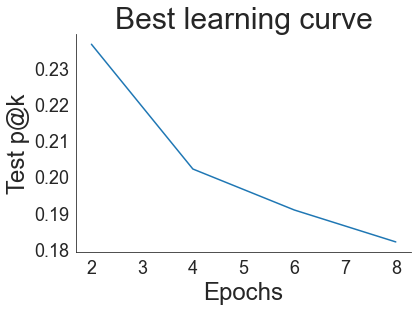

In [113]:
import seaborn as sns
sns.set_style('white')
fig, ax = plt.subplots()
sns.despine(fig);
plt.plot([2, 4, 6, 8], best_curves[0]['patk']['test']);
plt.xlabel('Epochs', fontsize=24);
plt.ylabel('Test p@k', fontsize=24);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.title('Best learning curve', fontsize=30);

Параметры для поиска лучших параметров взяла меньше, так как слишком долго работает поиск
по результатам выявлены лучшие параметры и построен график зависимости p@k от количества эпох {'num_factors': 120, 'regularization': 10.0, 'alpha': 500}
0.23666499246609746
Epoch: 2

если анализировать результаты по всем параметрам - возможно получить лучший результат, например увеличив количество эпох